# Using a support vector machine for sweep model selection
This example is similar to `demographicModelSelectionExample.ipynb` in that we are going to use supervised machine learning to discriminate between three classes of simulated data. But here rather than thinking about demography we are trying to determine whether a given locus has experienced a recent selective sweep or not, and whether this sweep was driven by de novo mutation (i.e. a classic "hard sweep" [1]) or an allele that was previously segregating in the population under drift but then became beneficial after some environmental change (i.e. a "soft sweep" [2]).

This example is a little bit more practical than our other example, where we were selecting a demographic model on the basis of a single locus rather than data from many loci as is typically done. Determining whether a locus has been recently impacted by positive selection is a common problem in population genetics, and this example shows that machine learning can be used to attack this problem without an inordinate amount of coding (modulo some caveats, discussed below)

Another difference between this example and our previous one is that we will use a support vector machine (SVM) for this task rather than a random forest, simply to demonstrate the proper use of this tool using scikit-learn. As we will see, switching between ML tools is very easy in scikit-learn.

## Preliminaries
The road map here will be to 1) do some simulation of three demographic models, 2) to train a classifier to distinguish among those models, 3) test that classifier with new simulation data, and 4) to graphically present how well our trained classifier works. 

To do this we will use coalescent simulations as implemented in our `discoal` software tool and for the ML side of things we will use the `scikit-learn` package. As before, we will use Dick Hudson's sample_stats program to calculate summary statistics, which we have included in our tarball containing his `ms` software. Let's start by installing these dependencies (if you don't have them installed already)

### Install and compile `sample_stats`
We have put a copy of the `ms` tarball in this repo, so the following should work upon cloning. (Note that this step is not required if you have already gone through `demographicModelSelectionExample.ipynb`.)

In [3]:
#untar and compile sample_stats
!tar zxf ms.tar.gz; cd msdir; gcc -o sample_stats sample_stats.c tajd.c -lm
#now move the program into the current working dir
!mv msdir/sample_stats .

### Install and compile `discoal`

We have to install the coalescent simulator `discoal` which we will use to simulate loci with and without selective sweeps. This is obtained from our github page as follows:

In [ ]:
#download discoal and compile it
!wget https://github.com/kern-lab/discoal/archive/master.zip; unzip master.zip; cd discoal-master; make
#or, for our mac OS X users and any others who use curl instead of wget
!curl -O https://github.com/kern-lab/discoal/archive/master.zip; unzip master.zip; cd discoal-master; make
#now move discoal into the current working dir
!mv discoal-master/discoal .

### Install `scikit-learn`
If you use anaconda or have gone through any of our other examples, you may already have these modules installed, but if not you can install with either of the following:

In [ ]:
!conda install scikit-learn

or if you don't use `conda`, you can use `pip` to install scikit-learn with

In [ ]:
!pip install -U scikit-learn

# Step 1: create a training set and a testing set
We will create a training set using simulations from three different demographic models: equilibrium population size, instantaneous population growth, and instantaneous population contraction. As you'll see this is really just a toy example because we will perform classification based on data from a single locus; in practice this would be ill-advised and you would want to use data from many loci simulataneously. 

So lets do some simulation using `ms` and summarize those simulations using the `sample_stats` program that Hudson provides. Ultimately we will only use two summary stats for classification, but one could use many more. Each of these simulations should take a few seconds to run.

In [37]:
#simulate under the equilibrium model -- could also do this with ms
!./discoal 20 1000 1000 -t 100 -r 100 | ./sample_stats > no_sweep.msOut.stats

In [63]:
#simulate under the soft sweep model with a selection coefficient 2Ns=250
#and an initial selected frequency randomly drawn from (0, 0.2]
!./discoal 20 1000 1000 -t 100 -r 100 -ws 0 -Pa 100 500 -i 4 -Pf 0 0.2 | ./sample_stats > soft_sweep.msOut.stats

In [64]:
#simulate under the hard sweep model with a selection coefficient 2Ns=250
!./discoal 20 1000 1000 -t 100 -r 100 -ws 0 -Pa 100 500 -i 4 | ./sample_stats > hard_sweep.msOut.stats

In [65]:
#now lets suck up the data columns we want for each of these files, and create one big training set; we will use numpy for this
# note that we are only using two columns of the data- these correspond to segSites and Fay & Wu's H
import numpy as np
X1 = np.loadtxt("no_sweep.msOut.stats",usecols=(5,9))
X2 = np.loadtxt("soft_sweep.msOut.stats",usecols=(5,9))
X3 = np.loadtxt("hard_sweep.msOut.stats",usecols=(5,9))
X = np.concatenate((X1,X2,X3))

#create associated 'labels' -- these will be the targets for training
y = [0]*len(X1) + [1]*len(X2) + [2]*len(X3)
Y = np.array(y)


In [66]:
#the last step in this process will be to shuffle the data, and then split it into a training set and a testing set
#the testing set will NOT be used during training, and will allow us to check how well the classifier is doing
#scikit-learn has a very convenient function for doing this shuffle and split operation
#
# will will keep out 25% of the data for testing

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25)

# Step 2: train our classifier and visualize decision surface
Now that we have a training and testing set ready to go, we can move on to training our classifier. For this example we will use a random forest classifier (Breiman 2001). This is all implemented in `scikit-learn` and so the code is very brief. 

In [67]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

#clf = RandomForestClassifier(n_estimators=100,n_jobs=10)
clf = svm.SVC(kernel='rbf', gamma=0.1, C=1)
clf = clf.fit(X_train, Y_train)


That's it! The classifier is trained. This SVM uses a radial basis kernel function which allows for non-linear classification. The `gamma` parameter is a hyperparameter of this kernel function, and `C` is the SVM's regularization parameter, which governs the "softness" of the separating margin. (An explanation of these and other concepts integral to understanding the guts of an SVM is beyond the scope of this example, though scikit-learn provides a nice fairly accessible tutorial with more example code here: http://scikit-learn.org/stable/modules/svm.html.) The values of these parameters were arbitrarily chosen, but work well enough to get the job done as we will see. We will also demonstrate a straightforward approach to selecting more optimal values later on.

Confession: the real reason we are using only two summary statistics right here is because it makes it really easy to visualize that classifier's decision surface: which regions of the feature space would be assigned to which class? Let's have a look! This code is identical to the decision-surface plotting code from `demographicModelSelectionExample.ipynb` even though we have switched to an SVM--scikit-learn very nicely maintains abstraction of different types of classifiers which makes these sorts of changes headache-free. The SVM classifier is a bit slower in this case so it might take a couple minutes.

(Note: I have increased the h argument for the call to `make_meshgrid` below, coarsening the contour plot in the interest of efficiency. Decreasing this will yield a smoother plot, but may take a while and use up a lot more memory. Adjust at your own risk!)

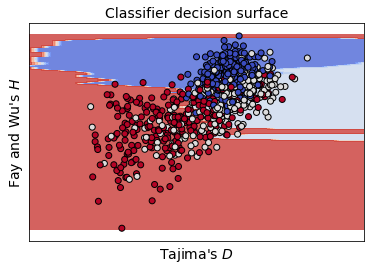

In [68]:
#These two functions (taken from scikit-learn.org) plot the decision boundaries for a classifier.
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.05):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

#Let's do the plotting
import matplotlib.pyplot as plt
fig,ax= plt.subplots(1,1)
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1, h=0.2)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.coolwarm, edgecolors='k')
ax.set_xlabel(r"Tajima's $D$", fontsize=14)
ax.set_ylabel(r"Fay and Wu's $H$", fontsize=14)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Classifier decision surface", fontsize=14)
plt.show()

Above we can see which regions of our feature space are assigned to each class: dark blue shaded areas will be classified as equilibrium, faint blue as soft sweeeps, and red as hard sweeps. Note that SVMs, like random forests, are able to produce non-linear decision boundaries. Looks like this might be a fairly tough problem, so let's try to quantify our accuracy.

# Step 3: benchmark our classifier
The last step of the process is to use our trained classifier to predict which demographic models our test data are drawn from. Recall that the classifier hasn't seen these test data so this should be a fair test of how well the classifier will perform on any new data we throw at it in the future. We will visualize performance using a confusion matrix. Those code is all identical to corresponding section in `demographicModelSelectionExample.ipynb`, with the exception of the class names.

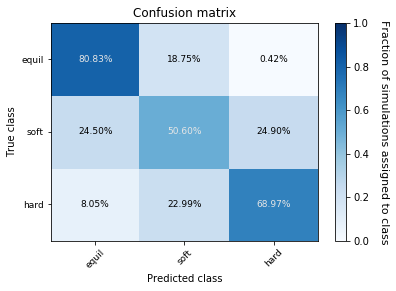

In [69]:
from sklearn.preprocessing import normalize

#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    
#now the actual work
#first get the predictions
preds=clf.predict(X_test)

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(Y_test)):
    counts[Y_test[i]][preds[i]] += 1
counts.reverse()
classOrderLs=['equil','soft','hard']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

Meh. Let's again see if we can do better by using all of statistics calculated by Hudson's `sample_stats`

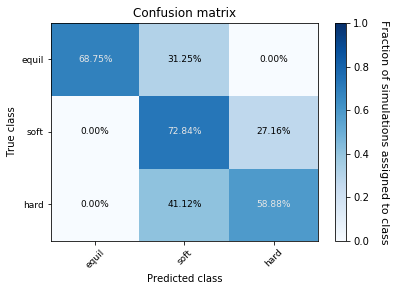

In [76]:
X1 = np.loadtxt("no_sweep.msOut.stats",usecols=(1,3,5,7,9))
X2 = np.loadtxt("soft_sweep.msOut.stats",usecols=(1,3,5,7,9))
X3 = np.loadtxt("hard_sweep.msOut.stats",usecols=(1,3,5,7,9))
X = np.concatenate((X1,X2,X3))
#create associated 'labels' -- these will be the targets for training
y = [0]*len(X1) + [1]*len(X2) + [2]*len(X3)
Y = np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)
clf = svm.SVC(kernel='rbf', gamma=0.1, C=1)
clf = clf.fit(X_train, Y_train)
preds=clf.predict(X_test)
counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(Y_test)):
    counts[Y_test[i]][preds[i]] += 1
counts.reverse()
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

Hmm, that didn't help all that much. But there is still room for improvement.

# Step 4: Improving accuracy using a grid search of SVM hyperparameters

This section title sounds fancy but this is actually pretty straightforward: we want to pick optimal values of the `gamma` and `C` hyperparameters used to train our SVM. This is typically done by examining a grid of values, which scikit-learn makes very easy for us. This will take a bit of CPU time as we are training a support vector machine for each combination of these two parameters along our grid. But hang in there, with this dataset and it should take no more than a minute or two.

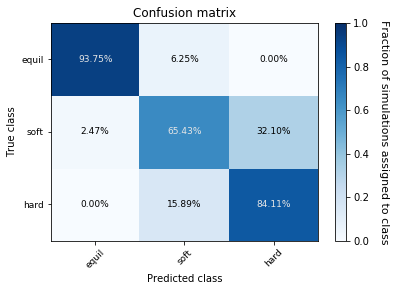

In [77]:
from sklearn.model_selection import GridSearchCV

## insert the grid search code here
param_grid = [
    {'C': [0.125, 0.25, 0.5, 1, 2, 4, 8],
     'gamma': [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],
     'kernel': ['rbf']},
 ]
clf = svm.SVC()
clf = GridSearchCV(clf, param_grid)
clf.fit(X_train,Y_train)

preds=clf.predict(X_test)
counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(Y_test)):
    counts[Y_test[i]][preds[i]] += 1
counts.reverse()
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

Now that looks better! This demonstrates that the grid search is a pretty important part of the SVM pipeline.

# Concluding remarks

Hopefully this example was helpful for 1) Learning a little bit about SVMs. 2) Getting an idea of how one can easily swap between different machine learning algorithms in scikit-learn by changing only a few lines of code. 3) See how one can fairly quickly create a machine learning tool that could be used in practice on population genetic data. Again here we are assuming that our population size has been constant, and violations of our modeling assumptions could cause problems--though if anything this problem is even more severe for non-ML methods. Departures from equilibrium can be handled by adjusting the demography of the training simulations accordingly. There are also a few machine learning methods for sweep detection that by virtue of their feature vector design are more robust to demographic model misspecification (e.g. [3] and to a lesser extent [4]).

# References

1. Maynard Smith J, Haigh J. The hitch-hiking effect of a favourable gene. Genet Res. 1974 Feb;23(1):23-35.
2. Hermisson J, Pennings PS. Soft sweeps: molecular population genetics of adaptation from standing genetic variation. Genetics. 2005 Apr;169(4):2335-52.
3. Schrider DR, Kern AD. S/HIC: Robust Identification of Soft and Hard Sweeps Using Machine Learning. PLoS Genet. 2016 Mar 15;12(3):e1005928.
4. Lin K, Li H, Schlötterer C, Futschik A. Distinguishing positive selection from neutral evolution: boosting the performance of summary statistics. Genetics. 2011 Jan;187(1):229-44.